In [18]:
import time
import random
import datetime
import matplotlib.pyplot as plt

In [19]:
def checkConflictsLinked(linked, return_list):
    import time
    # array is ArrayListEventStore to be searched for conflicts
    # return list is 1 to print a list of conflicts, 0 to skip printing (for large data sets)
    start_time = time.time() # start execution time

    # set variables to collect data
    checked = [] 
    conflicts = []
    conflict_id = []

    # zero counters
    con_instance = 0
    conflict_total = 0

    chk_point = linked.head
    while chk_point:
        
        #print(f"check point = {chk_point}")
        # Event parameters to check for conflicts
        chk_sked = chk_point.event.getTimestamp() # timestamp
        chk_loc = chk_point.event.getLocation() # location
        #print(f"chk_sked = {chk_sked}")
        #print(f"chk_loc = {chk_loc}")

        chk_combo = chk_loc + '_' + str(chk_sked) # date / time / location combined

        # check if date / time / location combination has been checked for conflicts already
        # if so, skip to next combination
        if(chk_combo in checked):
            #print(f"{chk_combo} already checked")
            chk_point = chk_point.next
            continue
        # if date / time / location combination has not been checked for conflicts, continue
        else:
            checked.append(chk_combo) # note combination being checked 
            #print(f"checking {chk_combo}")

        conflict_count = 0 # zero conflict count        

        # comparison starts with next event after event being checked
        query = chk_point.next
        

        while query:
            #print(f"query = {query}")

            # if match of timestamp and location
            #print(f"Timestamp compare: {query.event.getTimestamp()} vs {chk_sked}")
            #print(f"Location compare: {query.event.getLocation()} vx {chk_loc}")
            if(query.event.getTimestamp() == chk_sked and query.event.getLocation() == chk_loc):
                conflict_count +=1
                # if first conflict instance, note both event ids
                if(conflict_count == 1):
                    conflict_id.append(chk_point.event.getId())
                    conflict_id.append(query.event.getId())
                # if subsequent conflict instance, note only new event id
                else:
                    conflict_id.append(query.event.getId())
                #print(f"conflict identified - count {conflict_count}")
                #print(f"query = {query}")
                              
            query = query.next
        # if reach the end of the search and conflicts have been identified
        # document conflict counts and details
        if(conflict_count > 0):
            conflicts.append([chk_combo, conflict_count])
            con_instance += 1
            conflict_total += conflict_count
        
        chk_point = chk_point.next
        #print(f"new check point = {chk_point}")
        
    end_time = time.time() # stop execution time
    conflict_chk_time = end_time - start_time # calculate run time

    print(f"{conflict_total} conflicts identified for {con_instance} time / loc combinations")

    #print(f"Conflict List: {conflicts}")

    print(f"Conflict checking time: {conflict_chk_time} s")
    if(return_list == 1):
        return conflict_total, con_instance, conflict_chk_time, conflict_id
    else:
        return conflict_total, con_instance, conflict_chk_time      


In [20]:
class Event():
    def __init__(self, id:int, title:str = None, date:str = "", time:str = "", location:str = ""):
        
        #self.date, self.time, self.timestamp, self.location = gen_event_details() #return date, time_start, timestamp, location
        
        self.id = id
        self.title = str(id) if title is None else title
        self.date = date
        self.time = time
        self.location = location #random.choice(loc)
        self.timestamp = self.make_timestamp()

    def make_timestamp(self):
        if not self.date or not self.time:
            return None
        d = self.date.replace("-", "")
        t = self.time.replace(":", "")
        return int(d+t)

    def getId(self):
        return self.id
    
    def getTitle(self):
        return self.title
    
    def getDate(self):
        return self.date
    
    def getTime(self):
        return self.time

    def getTimestamp(self):
        return self.timestamp
    
    def getLocation(self):
        return self.location

    def setDate(self, date:str):
        self.date = date

    def setTime(self, time:str):
        self.time = time
    
    def setLocation(self, location:str):
        self.location = location
        
    def __str__(self):
        return f"Event(ID: {self.id}, Title: {self.title}, Date: {self.date}, Time: {self.time}, Timestamp: {self.timestamp}, Location: {self.location})"


In [21]:
#import Event

class Node():
    def __init__(self, event:Event):
        self.event = event
        self.next = None

In [22]:
from abc import ABC, abstractmethod

class EventStore(ABC):
    
    @abstractmethod
    def insert_event(self, event):
        pass

    @abstractmethod
    def delete_event(self, event_id:int):
        pass

    @abstractmethod
    def search_by_id(self, event_id:int):
        pass

    @abstractmethod
    def list_all_events(self):
        pass

In [23]:
#from EventStore import EventStore
#from Event import Event
#from Node import Node

class LinkedListEventStore(EventStore):

    def __init__(self):
        self.head = None
        self.size = 0
    
    def insert_event(self, event):
        new_node = Node(event)
        if self.head is None:
            self.head = new_node
        else:
            current = self.head
            while current.next:
                current = current.next
            current.next = new_node

        self.size += 1

    def delete_event(self, event_id):

        prev = None
        current = self.head

        while current:
            if current.event.id == event_id:
                if prev:
                    prev.next = current.next
                else:
                    self.head = current.next
                self.size -= 1
                return True
            prev = current
            current = current.next
        return False
    
    def search_by_id(self, event_id):

        current = self.head
        while current:
            if current.event.id == event_id:
                return current.event
            current = current.next
        return None
    

    def list_all_events(self):
        events = []
        current = self.head
        while current:
            events.append(current.event)
            current = current.next
        return events

In [24]:
def test_event_fixed_linked(event_count):
    import random
    EventList = LinkedListEventStore()
    for i in range(event_count): 
        if (i//2 !=0 and i < 4):
            eventi = Event(i+1, f"Event {i+1}", "2026-01-01", "10:00", "Conf Rm 42")
        else:
            s = random.randint(1,event_count)
            if(s//2 == 0 and s>5):
                eventi = Event(i+1, f"Event {i+1}", "2026-07-13", "15:00", "Bldg 2")
            elif(s == 5): 
                eventi = Event(i+1, f"Event {i+1}", "2026-04-19", "18:00", "Bldg 2")
            elif(s//3 ==0): 
                eventi = Event(i+1, f"Event {i+1}", "2026-12-06", "06:00", "Bldg 1")
            else:
                eventi = Event(i+1, f"Event {i+1}", "2026-12-06", "10:00", "Bldg 2")
        print(f"Event generated {eventi}")
        EventList.insert_event(eventi)
        
    return EventList    

In [25]:
def testKnownDataLinked(event_count):
    test_known = test_event_fixed_linked(event_count)

    print("Linked List Conflict Check Results: Event Set with Known Conflicts")
    conflict_total0, con_instances0, conflict_chk_time0, conflict_id_list0 = checkConflictsLinked(test_known, 1)
    print(f"\nTotal conflicts identified: {conflict_total0}")
    print(f"Number of date/time/location combinations with conflicts: {con_instances0}")
    print(f"Time to run conflict checks: {conflict_chk_time0} s")
    print(f"Event IDs of events with conflicts: {conflict_id_list0}\n")

    for i in range(len(conflict_id_list0)):
        print(test_known.search_by_id(conflict_id_list0[i]))

    return conflict_total0, con_instances0, conflict_chk_time0, conflict_id_list0

In [26]:
testKnownDataLinked(10)

Event generated Event(ID: 1, Title: Event 1, Date: 2026-12-06, Time: 06:00, Timestamp: 202612060600, Location: Bldg 1)
Event generated Event(ID: 2, Title: Event 2, Date: 2026-12-06, Time: 10:00, Timestamp: 202612061000, Location: Bldg 2)
Event generated Event(ID: 3, Title: Event 3, Date: 2026-01-01, Time: 10:00, Timestamp: 202601011000, Location: Conf Rm 42)
Event generated Event(ID: 4, Title: Event 4, Date: 2026-01-01, Time: 10:00, Timestamp: 202601011000, Location: Conf Rm 42)
Event generated Event(ID: 5, Title: Event 5, Date: 2026-12-06, Time: 10:00, Timestamp: 202612061000, Location: Bldg 2)
Event generated Event(ID: 6, Title: Event 6, Date: 2026-12-06, Time: 10:00, Timestamp: 202612061000, Location: Bldg 2)
Event generated Event(ID: 7, Title: Event 7, Date: 2026-04-19, Time: 18:00, Timestamp: 202604191800, Location: Bldg 2)
Event generated Event(ID: 8, Title: Event 8, Date: 2026-12-06, Time: 10:00, Timestamp: 202612061000, Location: Bldg 2)
Event generated Event(ID: 9, Title: Even

(6, 3, 4.553794860839844e-05, [1, 10, 2, 5, 6, 8, 9, 3, 4])

In [27]:
class Event_Random():
    def __init__(self, id:int):#, title:str = None, date:str = "", time:str = "", location:str = ""):
        
        self.date, self.time, self.timestamp, self.location = gen_event_details() #return date, time_start, timestamp, location
        
        self.id = id
        self.title = str(id) #if title is None else title
        #self.date = date
        #self.time = time
        #self.location = random.choice(loc)
        #$self.timestamp = 

    def getId(self):
        return self.id
    
    def getTitle(self):
        return self.title
    
    def getDate(self):
        return self.date
    
    def getTime(self):
        return self.time

    def getTimestamp(self):
        return self.timestamp
    
    def getLocation(self):
        return self.location

    def setDate(self, date:str):
        self.date = date

    def setTime(self, time:str):
        self.time = time
    
    def setLocation(self, location:str):
        self.location = location
        
    def __str__(self):
        return f"Event(ID: {self.id}, Title: {self.title}, Date: {self.date}, Time: {self.time}, Timestamp: {self.timestamp}, Location: {self.location})"


In [28]:
def gen_event_details():
    import datetime
    import random
    
    # Parameters for random generation of dates, times, and locations
    year = [2026]
    day = [31,28,31,30,31,30,31,31,30,31,30,31]
    hour = range(1,24)
    minute = [0]
    loc = ["Bldg 1", "Bldg 2", "Bldg 6", "Conf Rm 13", "Conf Rm 42", "Parking Lot 3"]

    # Generate date
    y = random.choice(year)
    
    mon = random.randint(1,12)
    if(mon<10):
        m = '0'+str(mon) 
    else: m = str(mon)
         
    D = day[mon-1]
    dy = random.randint(1,D)
    if(dy<10):
        d = '0'+str(dy) 
    else: d = str(dy)

    # Generate time
    h = random.randint(1,23)
    if(h<10): 
        hh = '0' + str(h) 
    else: hh = str(h)
        
    mi = 0
    mm = '00' 
    
    # Date 
    date = str(y)+'-'+ m +'-'+ d
    
    # Start time
    time_start =  hh + ':' + mm

    # Location
    location = random.choice(loc)

    # Generate datetime & timestamp
    dt = datetime.datetime(y,mon,dy,h,mi)
    timestamp = dt.timestamp()

    return date, time_start, timestamp, location

In [29]:
def test_event_random_linked(event_count):
    EventList = LinkedListEventStore()
    for i in range(event_count):           
        eventi = Event_Random(i+1)#, f"Event {i}", date, time_start, location)
        if(event_count<15):print(f"Event generated {eventi}")
        EventList.insert_event(eventi)
        
    return EventList    

In [30]:
def testRandomDataLinked(event_count,print_conflicts):
    test_random = test_event_random_linked(event_count)

    print(f"Linked List Conflict Check Results: Random Event Set with {event_count} Events")
    if(print_conflicts == 0):
        conflict_total1, con_instances1, conflict_chk_time1 = checkConflictsLinked(test_random, print_conflicts)
    elif(print_conflicts == 1):
        conflict_total1, con_instances1, conflict_chk_time1, conflict_id_list1 = checkConflictsLinked(test_random, print_conflicts)
        
    print(f"\nTotal conflicts identified: {conflict_total1}")
    print(f"Number of date/time/location combinations with conflicts: {con_instances1}")
    print(f"Time to run conflict checks: {conflict_chk_time1} s")
    if(print_conflicts ==1):
        print(f"Event IDs of events with conflicts: {conflict_id_list1}")
        
        for i in range(len(conflict_id_list1)):
            print(test_random.search_by_id(conflict_id_list1[i]))
            
        return conflict_total1, con_instances1, conflict_chk_time1, conflict_id_list1
    else:
        return conflict_total1, con_instances1, conflict_chk_time1

In [31]:
testRandomDataLinked(10,1)

Event generated Event(ID: 1, Title: 1, Date: 2026-01-09, Time: 13:00, Timestamp: 1767988800.0, Location: Bldg 2)
Event generated Event(ID: 2, Title: 2, Date: 2026-02-22, Time: 23:00, Timestamp: 1771826400.0, Location: Conf Rm 42)
Event generated Event(ID: 3, Title: 3, Date: 2026-04-14, Time: 19:00, Timestamp: 1776214800.0, Location: Bldg 2)
Event generated Event(ID: 4, Title: 4, Date: 2026-01-31, Time: 23:00, Timestamp: 1769925600.0, Location: Conf Rm 13)
Event generated Event(ID: 5, Title: 5, Date: 2026-04-26, Time: 11:00, Timestamp: 1777222800.0, Location: Bldg 1)
Event generated Event(ID: 6, Title: 6, Date: 2026-06-05, Time: 02:00, Timestamp: 1780646400.0, Location: Bldg 2)
Event generated Event(ID: 7, Title: 7, Date: 2026-03-16, Time: 21:00, Timestamp: 1773716400.0, Location: Parking Lot 3)
Event generated Event(ID: 8, Title: 8, Date: 2026-02-16, Time: 12:00, Timestamp: 1771268400.0, Location: Conf Rm 13)
Event generated Event(ID: 9, Title: 9, Date: 2026-10-10, Time: 07:00, Timesta

(0, 0, 5.9604644775390625e-05, [])

In [32]:
testRandomDataLinked(500,1)

Linked List Conflict Check Results: Random Event Set with 500 Events
3 conflicts identified for 3 time / loc combinations
Conflict checking time: 0.010518789291381836 s

Total conflicts identified: 3
Number of date/time/location combinations with conflicts: 3
Time to run conflict checks: 0.010518789291381836 s
Event IDs of events with conflicts: [17, 39, 267, 483, 342, 356]
Event(ID: 17, Title: 17, Date: 2026-05-14, Time: 17:00, Timestamp: 1778799600.0, Location: Bldg 1)
Event(ID: 39, Title: 39, Date: 2026-05-14, Time: 17:00, Timestamp: 1778799600.0, Location: Bldg 1)
Event(ID: 267, Title: 267, Date: 2026-12-15, Time: 22:00, Timestamp: 1797397200.0, Location: Bldg 6)
Event(ID: 483, Title: 483, Date: 2026-12-15, Time: 22:00, Timestamp: 1797397200.0, Location: Bldg 6)
Event(ID: 342, Title: 342, Date: 2026-02-17, Time: 04:00, Timestamp: 1771326000.0, Location: Bldg 6)
Event(ID: 356, Title: 356, Date: 2026-02-17, Time: 04:00, Timestamp: 1771326000.0, Location: Bldg 6)


(3, 3, 0.010518789291381836, [17, 39, 267, 483, 342, 356])

In [33]:
def test_mult_cases_linked(test_inc):
    ind = 0

    n = len(test_inc)

    conflict_count_tot = [0] * n
    con_instances = [0] * n
    conflict_chk_time = [0] * n
    conflict_id_list = [0] * n

    for m in range(n):
        z = test_inc[m]
        print(f"checking {z} events")
        #print(z)

        conflict_count_tot[m], con_instances[m], conflict_chk_time[m] = testRandomDataLinked(z,0)

    import matplotlib.pyplot as plt

    plt.plot(test_inc, conflict_chk_time, marker='o', linestyle='-', color='blue', label='?')
    plt.xlabel("Events Checked")
    plt.ylabel("Time (s)")
    plt.title("Time to Execute Conflict Checking for Linked List")
    plt.grid(True)
    plt.show()


checking 50 events
Linked List Conflict Check Results: Random Event Set with 50 Events
0 conflicts identified for 0 time / loc combinations
Conflict checking time: 0.00031256675720214844 s

Total conflicts identified: 0
Number of date/time/location combinations with conflicts: 0
Time to run conflict checks: 0.00031256675720214844 s
checking 500 events
Linked List Conflict Check Results: Random Event Set with 500 Events
1 conflicts identified for 1 time / loc combinations
Conflict checking time: 0.010601520538330078 s

Total conflicts identified: 1
Number of date/time/location combinations with conflicts: 1
Time to run conflict checks: 0.010601520538330078 s
checking 1000 events
Linked List Conflict Check Results: Random Event Set with 1000 Events
9 conflicts identified for 9 time / loc combinations
Conflict checking time: 0.05824637413024902 s

Total conflicts identified: 9
Number of date/time/location combinations with conflicts: 9
Time to run conflict checks: 0.05824637413024902 s
ch

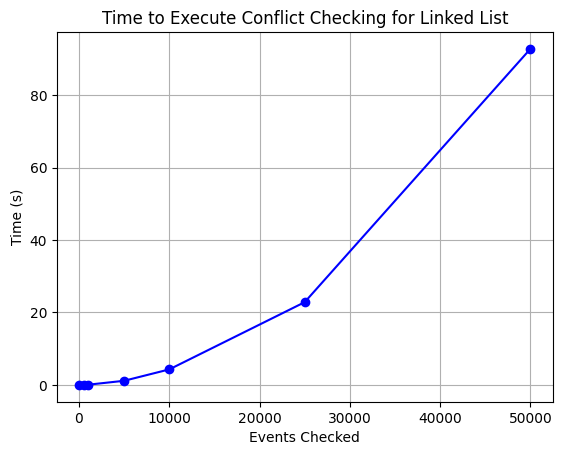

In [34]:
test_inc = (50,500,1000,5000,10000,25000,50000)

test_mult_cases_linked(test_inc)